In [1]:
from random import shuffle

import os
import numpy as np
import torch
import torchvision
from matplotlib import pyplot as plt
from torch import nn
from torch.nn import functional as F
from torchvision import transforms
from tqdm import tqdm, tqdm_notebook

from data_utils import ImageClipDataset, split_clips_dataset
from models import residual_attention_network

In [2]:
BATCH_SIZE = 16
NUM_THREADS = 2
num_epochs = 50

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        #transforms.RandomAffine(15, (0.2, 0.2)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])
}

In [5]:
clips = ImageClipDataset('./data/images/', transform=data_transforms['train'])

In [6]:
print(clips)

Dataset ImageClipDataset
    Number of classes: 11
    Number of videos: 1100
    Number of datapoints: 5488
    Root Location: D:\Studies\FEEC\sumarizacao\data\images
    Transforms (if any): Compose(
                             Resize(size=256, interpolation=PIL.Image.BILINEAR)
                             CenterCrop(size=(224, 224))
                             ToTensor()
                             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                         )
    Target Transforms (if any): None


In [7]:
train_set, validation_set = split_clips_dataset(clips, 0.2)

In [8]:
validation_set = ImageClipDataset(validation_set.root, data_transforms['test'], videos=validation_set.videos_per_class)

In [9]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                           shuffle=True, num_workers=NUM_THREADS,
                                           pin_memory=torch.cuda.is_available())
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=BATCH_SIZE,
                                                shuffle=False, num_workers=NUM_THREADS,
                                                pin_memory=torch.cuda.is_available())

In [10]:
class AttentionNetwork56(nn.Module):
    # Well, look... Something is off. Sizes should be divided by 2 after the residual layers.
    def __init__(self):
        super().__init__()
        self.maxpool = nn.MaxPool2d(3, 2, 1)
        self.avgpool = nn.AvgPool2d(7, 1)
        
        self.conv1 = nn.Conv2d(3, 64, 7, 2, 3)
        
        self.residual1 = residual_attention_network.make_residual_layer(
            torchvision.models.resnet.Bottleneck,
            64,
            64//2,
            1
        )
        self.attention1 = residual_attention_network.AttentionModule(256//2, 128//2, 1, 2, 1)
        self.residual2 = residual_attention_network.make_residual_layer(
            torchvision.models.resnet.Bottleneck,
            512//2,
            128//2,
            1
        )
        self.attention2 = residual_attention_network.AttentionModule(512//2, 256//2, 1, 2, 1)
        self.residual3 = residual_attention_network.make_residual_layer(
            torchvision.models.resnet.Bottleneck,
            1024//2,
            256//2,
            1
        )
        self.attention3 = residual_attention_network.AttentionModule(1024//2, 512//2, 1, 2, 1)
        self.residual4 = residual_attention_network.make_residual_layer(
            torchvision.models.resnet.Bottleneck,
            2048//2,
            512//2,
            3
        )
        self.clf = nn.Linear(in_features=2048//2, out_features=11)

    def forward(self, input):
        x = self.conv1(input)
        x = self.maxpool(x)
        
        x = self.residual1(x)
        x = self.attention1(x)
        
        x = self.residual2(x)
        x = self.maxpool(x)
        x = self.attention2(x)

        x = self.residual3(x)
        x = self.maxpool(x)
        x = self.attention3(x)
        
        x = self.residual4(x)
        x = self.maxpool(x)
        x = self.avgpool(x)
        
        x = x.view(x.shape[0], -1)
        x = self.clf(x)
        
        return x

In [11]:
att_net = AttentionNetwork56()
att_net = att_net.to(device)

In [12]:
optimizer = torch.optim.SGD(att_net.parameters(), lr=1e-1, momentum=.9)
criterion = nn.CrossEntropyLoss()

In [13]:
loss_history = []
hit_history = []
val_loss_history = []
val_hit_history = []
for epoch in tqdm_notebook(range(0, num_epochs), leave=False, desc='Epochs'):
    hits = 0
    epoch_loss = 0
    for (images, targets, video, clip) in tqdm_notebook(train_loader, leave=False, desc='Training Batches'):
        images, targets = images.to(device), targets.to(device)

        optimizer.zero_grad()
        output = att_net(images)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
        
        predictions = output.max(dim=1)[1]
        hits += (predictions == targets).sum()
        epoch_loss += loss.item()

    optimizer.zero_grad()
    
    loss_history.append(epoch_loss)
    hit_history.append(hits)
    
    with torch.no_grad():
        val_hits = 0
        val_loss = 0
        for (images, targets, _, _) in tqdm_notebook(validation_loader, leave=False, desc='Validation Batches
                                                     '):
            images, targets = images.to(device), targets.to(device)

            output = att_net(images)
            loss = criterion(output, targets)
            
            predictions = output.max(dim=1)[1]
            val_hits += (predictions == targets).sum()
            val_loss += loss.item()
            
        val_loss_history.append(val_loss)
        val_hit_history.append(val_hits)

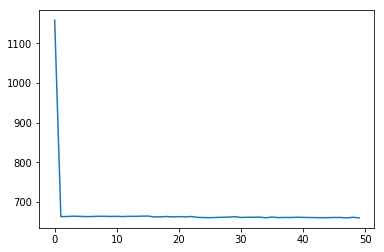

In [14]:
plt.plot(loss_history)

In [15]:
acc = torch.Tensor(hit_history) / len(train_set.samples)

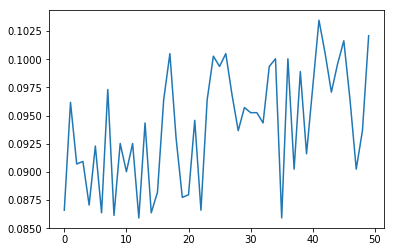

In [16]:
plt.plot(acc.tolist())

In [17]:
val_acc = torch.Tensor(val_hit_history) / len(validation_set.samples)

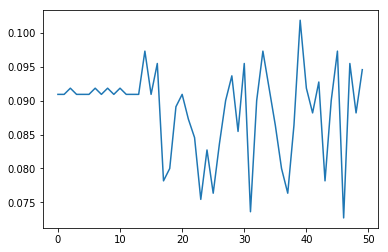

In [18]:
plt.plot(val_acc.tolist())

In [19]:
acc

tensor([0.0866, 0.0962, 0.0907, 0.0909, 0.0871, 0.0923, 0.0864, 0.0973, 0.0861,
        0.0925, 0.0900, 0.0925, 0.0859, 0.0943, 0.0864, 0.0882, 0.0964, 0.1005,
        0.0930, 0.0877, 0.0880, 0.0946, 0.0866, 0.0964, 0.1003, 0.0994, 0.1005,
        0.0969, 0.0937, 0.0957, 0.0953, 0.0953, 0.0943, 0.0994, 0.1000, 0.0859,
        0.1000, 0.0902, 0.0989, 0.0916, 0.0975, 0.1035, 0.1005, 0.0971, 0.0996,
        0.1016, 0.0964, 0.0902, 0.0937, 0.1021])

In [20]:
val_acc

tensor([0.0909, 0.0909, 0.0918, 0.0909, 0.0909, 0.0909, 0.0918, 0.0909, 0.0918,
        0.0909, 0.0918, 0.0909, 0.0909, 0.0909, 0.0973, 0.0909, 0.0955, 0.0782,
        0.0800, 0.0891, 0.0909, 0.0873, 0.0845, 0.0755, 0.0827, 0.0764, 0.0836,
        0.0900, 0.0936, 0.0855, 0.0955, 0.0736, 0.0900, 0.0973, 0.0918, 0.0864,
        0.0800, 0.0764, 0.0864, 0.1018, 0.0918, 0.0882, 0.0927, 0.0782, 0.0900,
        0.0973, 0.0727, 0.0955, 0.0882, 0.0945])

## TODO
1. Regularizar (L! pra esparsificar)
2. Mais videos e mais frames por video
3. Classificação por video (maioria no vídeo)
4. Estado de atenção